In [ ]:
pip install ultralytics numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
%%writefile density.py

def compute_density(people_count: int, frame_area: int) -> float:
    """
    Computes crowd density as people per pixel area.

    Args:
        people_count (int): Number of detected people in the frame
        frame_area (int): Width * Height of the frame

    Returns:
        float: crowd density score
    """

    if frame_area == 0:
        return 0.0

    density_score = people_count / frame_area
    return density_score

Writing density.py


In [ ]:
%%writefile threshold.py

# Density thresholds (tune these using sample videos)
LOW_DENSITY_THRESHOLD = 0.00002
MEDIUM_DENSITY_THRESHOLD = 0.00005

# Alert thresholds for each crowd level
ALERT_THRESHOLDS = {
    "LOW": 0.4,     # high sensitivity
    "MEDIUM": 0.6,
    "HIGH": 0.8     # strict alerting
}


def get_crowd_level(density_score: float) -> str:
    """
    Classifies crowd level based on density score.
    """

    if density_score < LOW_DENSITY_THRESHOLD:
        return "LOW"
    elif density_score < MEDIUM_DENSITY_THRESHOLD:
        return "MEDIUM"
    else:
        return "HIGH"


def get_threshold(density_score: float):
    """
    Returns crowd level and corresponding alert threshold.
    """

    crowd_level = get_crowd_level(density_score)
    alert_threshold = ALERT_THRESHOLDS[crowd_level]

    return crowd_level, alert_threshold

Writing threshold.py


In [ ]:
%%writefile utils.py

from collections import deque


class MovingAverage:
    """
    Smooths noisy values like density over time.
    """

    def __init__(self, window_size=5):
        self.window_size = window_size
        self.values = deque(maxlen=window_size)

    def update(self, value: float) -> float:
        self.values.append(value)
        return sum(self.values) / len(self.values)


def print_crowd_info(frame_id, people_count, density, crowd_level, threshold):
    """
    Utility function for clean logging.
    """

    print(
        f"Frame {frame_id} | "
        f"People: {people_count} | "
        f"Density: {density:.6f} | "
        f"Level: {crowd_level} | "
        f"Threshold: {threshold}"
    )

Writing utils.py



0: 384x640 10 persons, 204.4ms
Speed: 19.4ms preprocess, 204.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


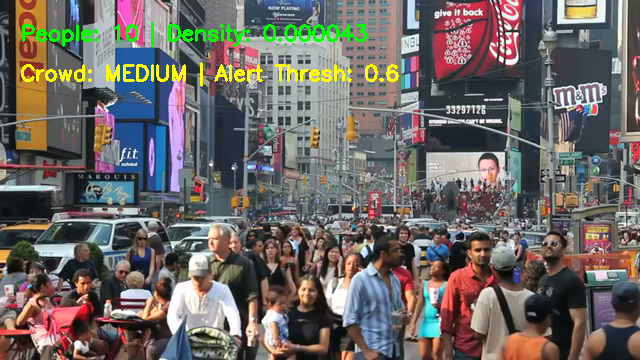


0: 384x640 10 persons, 193.6ms
Speed: 3.1ms preprocess, 193.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


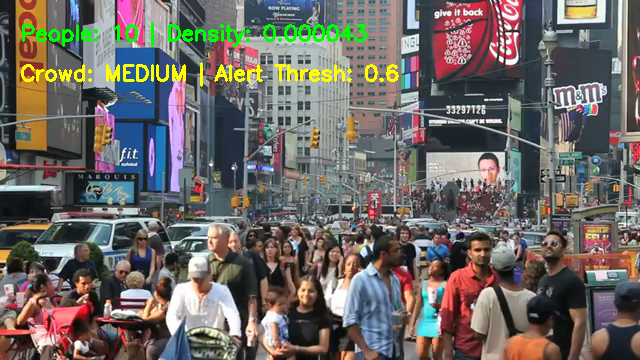


0: 384x640 9 persons, 200.6ms
Speed: 2.8ms preprocess, 200.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


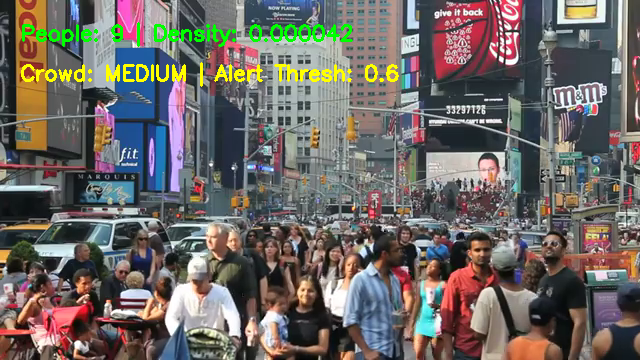


0: 384x640 9 persons, 213.3ms
Speed: 3.9ms preprocess, 213.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


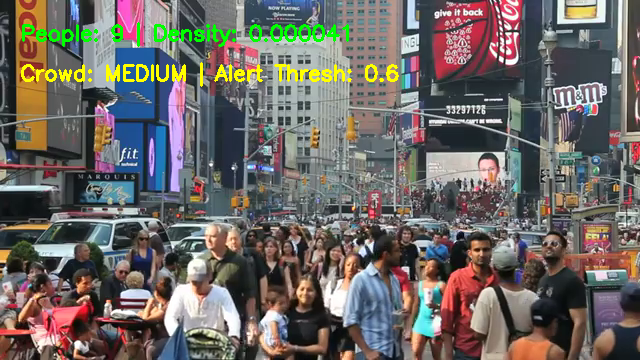


0: 384x640 9 persons, 232.5ms
Speed: 3.1ms preprocess, 232.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


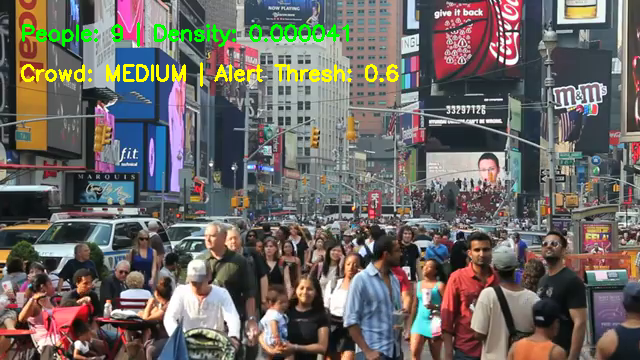


0: 384x640 7 persons, 214.1ms
Speed: 3.1ms preprocess, 214.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


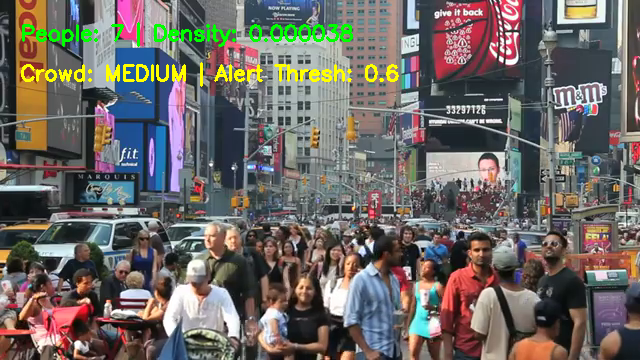


0: 384x640 8 persons, 220.1ms
Speed: 4.3ms preprocess, 220.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


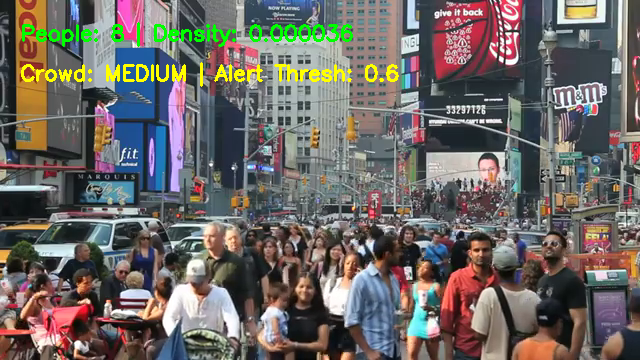


0: 384x640 8 persons, 233.3ms
Speed: 3.2ms preprocess, 233.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


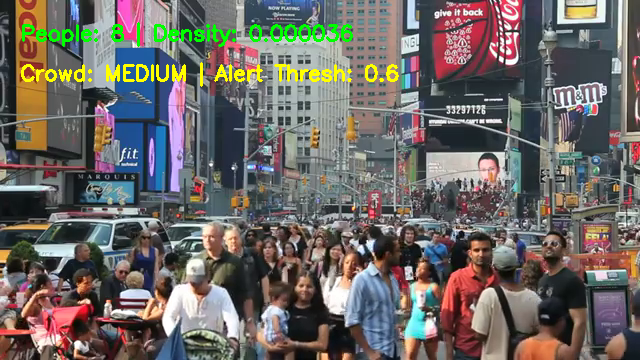


0: 384x640 8 persons, 240.3ms
Speed: 2.7ms preprocess, 240.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


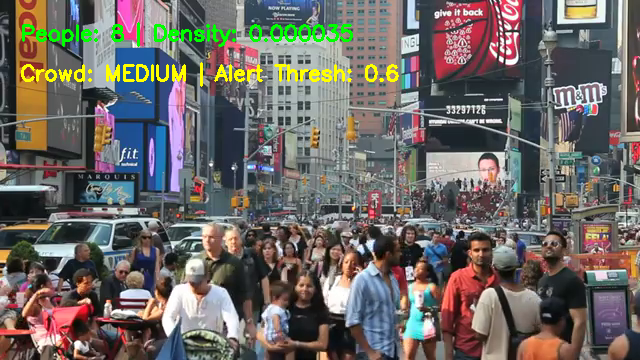


0: 384x640 8 persons, 229.8ms
Speed: 2.9ms preprocess, 229.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


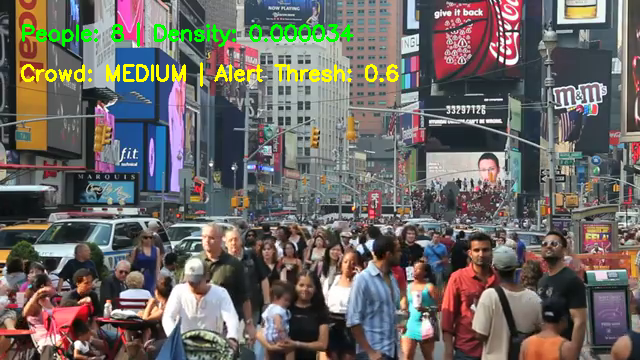


0: 384x640 9 persons, 234.7ms
Speed: 2.0ms preprocess, 234.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


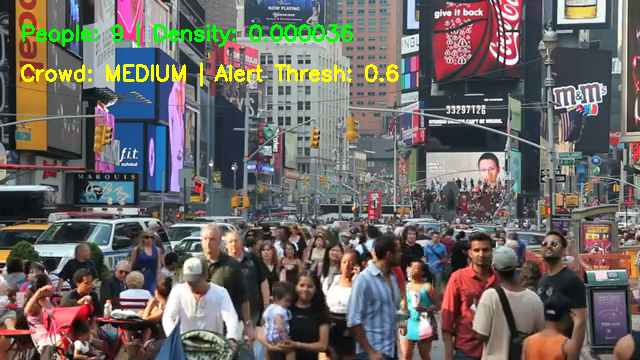


0: 384x640 8 persons, 259.7ms
Speed: 5.4ms preprocess, 259.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


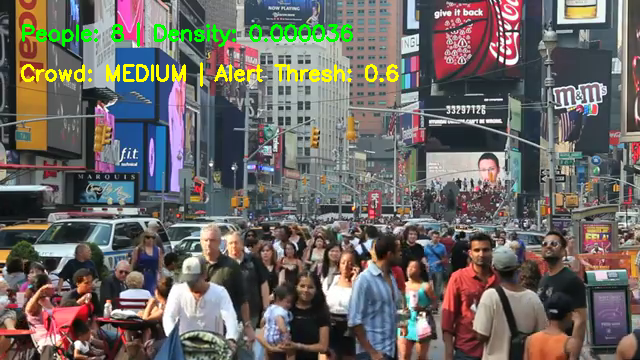


0: 384x640 10 persons, 228.9ms
Speed: 1.9ms preprocess, 228.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


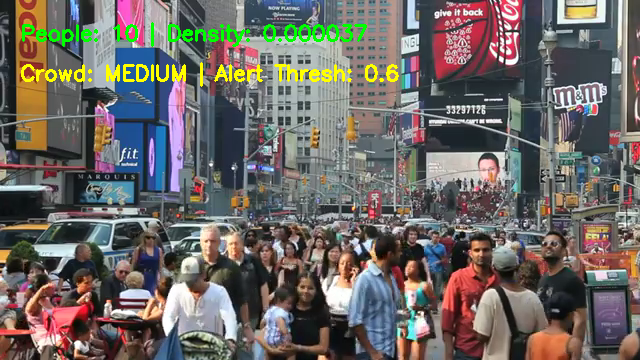


0: 384x640 8 persons, 219.4ms
Speed: 2.8ms preprocess, 219.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


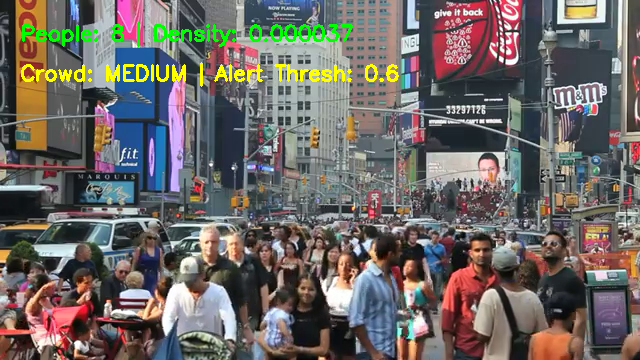


0: 384x640 7 persons, 215.4ms
Speed: 4.0ms preprocess, 215.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


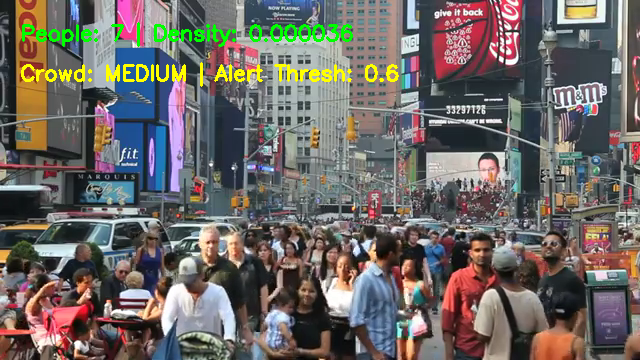

KeyboardInterrupt: 

In [ ]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow # Import cv2_imshow

from density import compute_density
from threshold import get_threshold
from utils import MovingAverage

# Load YOLOv8 pre-trained model
model = YOLO("yolov8n.pt")

# Open video
cap = cv2.VideoCapture("test4.mp4") # Updated video path

density_smoother = MovingAverage(window_size=5)

people_count = 0 # Initialize people_count outside the loop

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_height, frame_width, _ = frame.shape
    frame_area = frame_width * frame_height

    # Run person detection
    results = model(frame, conf=0.4, classes=[0])  # class 0 = person
    people_count = len(results[0].boxes)

    # Compute density
    raw_density = compute_density(people_count, frame_area)
    smooth_density = density_smoother.update(raw_density)

    # Get crowd level & adaptive threshold
    crowd_level, threshold = get_threshold(smooth_density)

    # Display info
    cv2.putText(
        frame,
        f"People: {people_count} | Density: {smooth_density:.6f}",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2
    )

    cv2.putText(
        frame,
        f"Crowd: {crowd_level} | Alert Thresh: {threshold}",
        (20, 80),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 255),
        2
    )

    cv2_imshow(frame) # Use cv2_imshow instead of cv2.imshow

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
print("People detected:", people_count)